In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import mat73
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

from scipy.signal import find_peaks
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import r2_score
import psutil
import os
import time

In [ ]:
wandb.login()
# run = wandb.init(project="master-multicomponent-mri", name="unet-baseline-fullpatch")
run = wandb.init(project="master-multicomponent-mri", name="unet-baseline-fullpatch-att-2")

wandb: Currently logged in as: tr-phan (trphan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
data = mat73.loadmat('../../data/training_data_T1_3D_9x9x32x47932_noise0.05.mat')
input_noisy_np = data['input_noisy']
input_clean_np = data['input']
ref_np = data['ref']

print("Shape of input data:", input_noisy_np.shape)
print("Shape of reference data:", ref_np.shape)

Shape of input data: (9, 9, 8, 47932)
Shape of reference data: (9, 9, 32, 47932)


In [4]:
nan_count_input_noisy_before = np.isnan(input_noisy_np).sum()
nan_count_ref_before = np.isnan(ref_np).sum()
print(f"NaN count in input_noisy before handling: {nan_count_input_noisy_before}")
print(f"NaN count in ref before handling: {nan_count_ref_before}")

NaN count in input_noisy before handling: 1635840
NaN count in ref before handling: 0


In [5]:
input_noisy_np = np.nan_to_num(input_noisy_np, nan=0.0)
nan_count_input_noisy_after = np.isnan(input_noisy_np).sum()
print(f"NaN count in input_noisy after handling: {nan_count_input_noisy_after}")

NaN count in input_noisy after handling: 0


In [6]:
class T1PatchDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return self.input_data[idx], self.target_data[idx]

In [7]:
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, in_channels//8, kernel_size=1),
            nn.BatchNorm2d(in_channels//8),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels//8, in_channels, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights

In [ ]:
class ResidualDoubleConvWithAttention(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(0.1),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )
        self.attention = SpatialAttention(out_channels)
        
        # residual connection
        self.residual = nn.Identity() if in_channels == out_channels else \
                       nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        identity = self.residual(x)
        x = self.double_conv(x)
        x = self.attention(x)
        return x + identity  # Residual connection

In [9]:
class UNetWithAttention(nn.Module):
    def __init__(self):
        super(UNetWithAttention, self).__init__()
        
        # Encoder path
        self.conv1 = ResidualDoubleConvWithAttention(8, 64)
        self.pool1 = nn.MaxPool2d(2, padding=1)
        self.conv2 = ResidualDoubleConvWithAttention(64, 128)
        
        # Bridge
        self.bridge_conv = ResidualDoubleConvWithAttention(128, 256)
        
        # Decoder path
        self.upconv = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = ResidualDoubleConvWithAttention(192, 128)  # 192 = 128 + 64 (skip connection)
        
        # Final convolutions with attention
        self.final_conv = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            SpatialAttention(64),
            nn.Conv2d(64, 32, kernel_size=1)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoding path
        conv1 = self.conv1(x)           # [batch, 64, 9, 9]
        x = self.pool1(conv1)           # [batch, 64, 5, 5]
        conv2 = self.conv2(x)           # [batch, 128, 5, 5]
        
        # Bridge
        x = self.bridge_conv(conv2)     # [batch, 256, 5, 5]
        
        # Decoding path
        x = self.upconv(x)              # [batch, 128, 10, 10]
        x = x[:, :, :9, :9]            # [batch, 128, 9, 9]
        x = torch.cat([x, conv1], dim=1)  # [batch, 192, 9, 9]
        x = self.conv3(x)               # [batch, 128, 9, 9]
        
        # Final convolutions
        x = self.final_conv(x)          # [batch, 32, 9, 9]
        
        return x

In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=1e-6, path='saved_model/best_unet_model_attention_2.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.path = path
        
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}). Saving model...')
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        else:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        torch.save({
            'model_state_dict': model.state_dict(),
            'val_loss': self.best_loss,
        }, self.path)

In [ ]:
# Transpose the input and reference data to be (N, C, H, W) format
input_noisy_torch = np.transpose(input_noisy_np, (3, 2, 0, 1))
ref_torch = np.transpose(ref_np, (3, 2, 0, 1))

input_noisy_torch = torch.tensor(input_noisy_torch, dtype=torch.float32)
ref_torch = torch.tensor(ref_torch, dtype=torch.float32)

In [12]:
input_mean = input_noisy_torch.mean()
input_std = input_noisy_torch.std()
input_noisy_torch = (input_noisy_torch - input_mean) / input_std

In [ ]:
# Create Dataset
dataset = T1PatchDataset(input_noisy_torch, ref_torch)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetWithAttention().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=6, verbose=True)
early_stopping = EarlyStopping(patience=10, path='best_unet_model_attention.pt')

num_epochs = 200

d:\Proton Drive\My files\Schule\Master\Masterarbeit\project\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [15]:
# Log configuration
wandb.config.update({
    "learning_rate": 0.001,
    "batch_size": batch_size,
    "epochs": num_epochs,
    "architecture": "UNet",
    "optimizer": "Adam",
    "loss_function": "MSELoss",
    "scheduler": "ReduceLROnPlateau",
    "early_stopping_patience": 10
})

In [16]:
# Training loop
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    progress_bar_train = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Training')
    
    for inputs, targets in progress_bar_train:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
        progress_bar_train.set_postfix({'loss': loss.item()})

    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    progress_bar_val = tqdm(val_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Validation')
    
    with torch.no_grad():
        for inputs, targets in progress_bar_val:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            progress_bar_val.set_postfix({'loss': loss.item()})

    avg_val_loss = val_loss / len(val_loader)

    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # Early stopping
    early_stopping(avg_val_loss, model)

    # Logging
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": current_lr
    })

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, LR: {current_lr}')

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print("Training finished")

Epoch [1/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 147.10it/s, loss=0.00312]


Validation loss decreased (inf --> 0.003171). Saving model...
Epoch [1/200], Train Loss: 0.007367495592140282, Val Loss: 0.0031714874769871435, LR: 0.001


Epoch [2/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 149.04it/s, loss=0.00292]


Validation loss decreased (0.003171 --> 0.002978). Saving model...
Epoch [2/200], Train Loss: 0.00298758373168918, Val Loss: 0.002978059450785319, LR: 0.001


Epoch [3/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 172.52it/s, loss=0.00248]


Validation loss decreased (0.002978 --> 0.002642). Saving model...
Epoch [3/200], Train Loss: 0.002669452977521966, Val Loss: 0.0026424399002765615, LR: 0.001


Epoch [4/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 160.44it/s, loss=0.00244]


Validation loss decreased (0.002642 --> 0.002522). Saving model...
Epoch [4/200], Train Loss: 0.0025087323606324693, Val Loss: 0.0025217341041813292, LR: 0.001


Epoch [5/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 163.14it/s, loss=0.00256]


Validation loss decreased (0.002522 --> 0.002449). Saving model...
Epoch [5/200], Train Loss: 0.0023934521987879027, Val Loss: 0.0024488283833488823, LR: 0.001


Epoch [6/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 169.73it/s, loss=0.00288]


EarlyStopping counter: 1 out of 10
Epoch [6/200], Train Loss: 0.00232022113360775, Val Loss: 0.0042672083200886845, LR: 0.001


Epoch [7/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 145.22it/s, loss=0.00211]


Validation loss decreased (0.002449 --> 0.002247). Saving model...
Epoch [7/200], Train Loss: 0.002330845697627713, Val Loss: 0.002247131441254169, LR: 0.001


Epoch [8/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 156.79it/s, loss=0.00198]


Validation loss decreased (0.002247 --> 0.002088). Saving model...
Epoch [8/200], Train Loss: 0.0022142007194148995, Val Loss: 0.0020884071104228497, LR: 0.001


Epoch [9/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 167.74it/s, loss=0.00202]


EarlyStopping counter: 1 out of 10
Epoch [9/200], Train Loss: 0.0021739166387123986, Val Loss: 0.002117620042990893, LR: 0.001


Epoch [10/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 156.88it/s, loss=0.0022] 


EarlyStopping counter: 2 out of 10
Epoch [10/200], Train Loss: 0.002131874961584496, Val Loss: 0.0022767127708842355, LR: 0.001


Epoch [11/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 149.36it/s, loss=0.00198]


Validation loss decreased (0.002088 --> 0.002064). Saving model...
Epoch [11/200], Train Loss: 0.002112273268091182, Val Loss: 0.002064374037242184, LR: 0.001


Epoch [12/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 152.89it/s, loss=0.00219]


EarlyStopping counter: 1 out of 10
Epoch [12/200], Train Loss: 0.0020608929437973228, Val Loss: 0.0024194911898424228, LR: 0.001


Epoch [13/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 155.99it/s, loss=0.00224]


EarlyStopping counter: 2 out of 10
Epoch [13/200], Train Loss: 0.002031640729207235, Val Loss: 0.0029827055692051847, LR: 0.001


Epoch [14/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 135.67it/s, loss=0.00215]


EarlyStopping counter: 3 out of 10
Epoch [14/200], Train Loss: 0.0021512942400295286, Val Loss: 0.0021575490206790465, LR: 0.001


Epoch [15/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 140.82it/s, loss=0.00186]


Validation loss decreased (0.002064 --> 0.002064). Saving model...
Epoch [15/200], Train Loss: 0.0021357060798133415, Val Loss: 0.0020641698331261673, LR: 0.001


Epoch [16/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 157.87it/s, loss=0.00202]


Validation loss decreased (0.002064 --> 0.002019). Saving model...
Epoch [16/200], Train Loss: 0.0020305331939986597, Val Loss: 0.0020193943412353597, LR: 0.001


Epoch [17/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 153.38it/s, loss=0.00191]


EarlyStopping counter: 1 out of 10
Epoch [17/200], Train Loss: 0.001994633387075737, Val Loss: 0.0020872177897642056, LR: 0.001


Epoch [18/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 135.78it/s, loss=0.00232]


EarlyStopping counter: 2 out of 10
Epoch [18/200], Train Loss: 0.001969701260095462, Val Loss: 0.002618658741315206, LR: 0.001


Epoch [19/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 142.28it/s, loss=0.00216]


EarlyStopping counter: 3 out of 10
Epoch [19/200], Train Loss: 0.002062926655053161, Val Loss: 0.0023150084742034477, LR: 0.001


Epoch [20/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 170.38it/s, loss=0.00181]


Validation loss decreased (0.002019 --> 0.001920). Saving model...
Epoch [20/200], Train Loss: 0.0019699804411114504, Val Loss: 0.001920101388047139, LR: 0.001


Epoch [21/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 168.65it/s, loss=0.00179]


EarlyStopping counter: 1 out of 10
Epoch [21/200], Train Loss: 0.001921920151410935, Val Loss: 0.001985924601710091, LR: 0.001


Epoch [22/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 149.52it/s, loss=0.00185]


Validation loss decreased (0.001920 --> 0.001841). Saving model...
Epoch [22/200], Train Loss: 0.001898683294421062, Val Loss: 0.0018413950029450158, LR: 0.001


Epoch [23/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 165.01it/s, loss=0.00175]


EarlyStopping counter: 1 out of 10
Epoch [23/200], Train Loss: 0.0018955681500180315, Val Loss: 0.0018681841956761976, LR: 0.001


Epoch [24/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 168.98it/s, loss=0.00176]


EarlyStopping counter: 2 out of 10
Epoch [24/200], Train Loss: 0.0018859337429360796, Val Loss: 0.0019079806422814727, LR: 0.001


Epoch [25/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 140.91it/s, loss=0.00174]


Validation loss decreased (0.001841 --> 0.001833). Saving model...
Epoch [25/200], Train Loss: 0.001865961702618127, Val Loss: 0.0018328896327875555, LR: 0.001


Epoch [26/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 140.64it/s, loss=0.00181]


EarlyStopping counter: 1 out of 10
Epoch [26/200], Train Loss: 0.0018433269656573732, Val Loss: 0.002272674546111375, LR: 0.001


Epoch [27/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 162.09it/s, loss=0.0018] 


EarlyStopping counter: 2 out of 10
Epoch [27/200], Train Loss: 0.0018359887048912545, Val Loss: 0.0018918539071455598, LR: 0.001


Epoch [28/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 145.59it/s, loss=0.00216]


EarlyStopping counter: 3 out of 10
Epoch [28/200], Train Loss: 0.0018263250531163067, Val Loss: 0.002142199375666678, LR: 0.001


Epoch [29/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 149.25it/s, loss=0.00173]


Validation loss decreased (0.001833 --> 0.001762). Saving model...
Epoch [29/200], Train Loss: 0.0018927354452898727, Val Loss: 0.0017621910176239908, LR: 0.001


Epoch [30/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 157.81it/s, loss=0.00173]


EarlyStopping counter: 1 out of 10
Epoch [30/200], Train Loss: 0.0018080379158103219, Val Loss: 0.0017991470025541883, LR: 0.001


Epoch [31/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 130.83it/s, loss=0.00173]


EarlyStopping counter: 2 out of 10
Epoch [31/200], Train Loss: 0.001793489959090948, Val Loss: 0.0018495455485147735, LR: 0.001


Epoch [32/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 157.83it/s, loss=0.00168]


EarlyStopping counter: 3 out of 10
Epoch [32/200], Train Loss: 0.0017800931483119104, Val Loss: 0.0017805597830253344, LR: 0.001


Epoch [33/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 156.01it/s, loss=0.00185]


EarlyStopping counter: 4 out of 10
Epoch [33/200], Train Loss: 0.001769382722947436, Val Loss: 0.0018504615601462623, LR: 0.001


Epoch [34/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 132.58it/s, loss=0.00168]


EarlyStopping counter: 5 out of 10
Epoch [34/200], Train Loss: 0.001775731127903176, Val Loss: 0.0018280179643382628, LR: 0.001


Epoch [35/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 152.81it/s, loss=0.00176]


EarlyStopping counter: 6 out of 10
Epoch [35/200], Train Loss: 0.0017552382966581112, Val Loss: 0.0017784354207105934, LR: 0.001


Epoch [36/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 152.55it/s, loss=0.00174]


Validation loss decreased (0.001762 --> 0.001750). Saving model...
Epoch [36/200], Train Loss: 0.0017444257420720533, Val Loss: 0.0017502631456591188, LR: 0.001


Epoch [37/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 154.25it/s, loss=0.00175]


EarlyStopping counter: 1 out of 10
Epoch [37/200], Train Loss: 0.0017369113363868867, Val Loss: 0.001852434241833786, LR: 0.001


Epoch [38/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 153.94it/s, loss=0.00178]


Validation loss decreased (0.001750 --> 0.001727). Saving model...
Epoch [38/200], Train Loss: 0.0017497411554601664, Val Loss: 0.0017274811421521007, LR: 0.001


Epoch [39/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 141.82it/s, loss=0.0018] 


EarlyStopping counter: 1 out of 10
Epoch [39/200], Train Loss: 0.0017217856567973892, Val Loss: 0.0017458548777115842, LR: 0.001


Epoch [40/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 143.42it/s, loss=0.00177]


EarlyStopping counter: 2 out of 10
Epoch [40/200], Train Loss: 0.0017090464245605593, Val Loss: 0.0017936972730482619, LR: 0.001


Epoch [41/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 152.63it/s, loss=0.0017] 


EarlyStopping counter: 3 out of 10
Epoch [41/200], Train Loss: 0.0017011146406487872, Val Loss: 0.0018033766350708902, LR: 0.001


Epoch [42/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 144.77it/s, loss=0.00179]


EarlyStopping counter: 4 out of 10
Epoch [42/200], Train Loss: 0.0016959906204526002, Val Loss: 0.0017860640313786765, LR: 0.001


Epoch [43/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 144.26it/s, loss=0.00163]


Validation loss decreased (0.001727 --> 0.001715). Saving model...
Epoch [43/200], Train Loss: 0.001684932213004989, Val Loss: 0.0017152191729595263, LR: 0.001


Epoch [44/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 143.39it/s, loss=0.00176]


EarlyStopping counter: 1 out of 10
Epoch [44/200], Train Loss: 0.0016766548992988343, Val Loss: 0.0017886612509998184, LR: 0.001


Epoch [45/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 138.15it/s, loss=0.00181]


EarlyStopping counter: 2 out of 10
Epoch [45/200], Train Loss: 0.0016587519903744881, Val Loss: 0.002048761874126891, LR: 0.001


Epoch [46/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 130.71it/s, loss=0.00164]


EarlyStopping counter: 3 out of 10
Epoch [46/200], Train Loss: 0.0016849929152522236, Val Loss: 0.0017464868778673311, LR: 0.001


Epoch [47/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 131.40it/s, loss=0.00169]


EarlyStopping counter: 4 out of 10
Epoch [47/200], Train Loss: 0.0016462705235850688, Val Loss: 0.0017720451795806488, LR: 0.001


Epoch [48/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 134.57it/s, loss=0.00173]


EarlyStopping counter: 5 out of 10
Epoch [48/200], Train Loss: 0.0016394678584765643, Val Loss: 0.0018210047429117063, LR: 0.001


Epoch [49/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 141.48it/s, loss=0.00171]


EarlyStopping counter: 6 out of 10
Epoch [49/200], Train Loss: 0.0016277006111340597, Val Loss: 0.0017220092114682, LR: 0.001


Epoch [50/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 142.08it/s, loss=0.00175]


EarlyStopping counter: 7 out of 10
Epoch [50/200], Train Loss: 0.0016191647230880334, Val Loss: 0.001855704412640383, LR: 0.0005


Epoch [51/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 140.92it/s, loss=0.00166]


EarlyStopping counter: 8 out of 10
Epoch [51/200], Train Loss: 0.001553356134487937, Val Loss: 0.0017409192436995606, LR: 0.0005


Epoch [52/200] Validation: 100%|██████████| 150/150 [00:01<00:00, 140.70it/s, loss=0.0017] 


EarlyStopping counter: 9 out of 10
Epoch [52/200], Train Loss: 0.0015331117634195834, Val Loss: 0.0017343825233789782, LR: 0.0005


Epoch [53/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 155.85it/s, loss=0.00169]

EarlyStopping counter: 10 out of 10
Epoch [53/200], Train Loss: 0.0015221531945280732, Val Loss: 0.001782783802288274, LR: 0.0005
Early stopping triggered
Training finished


In [ ]:
def calculate_psnr(target, prediction):
    """Calculate Peak Signal-to-Noise Ratio"""
    mse = np.mean((target - prediction) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = np.max(target)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_peak_metrics_patch(target, prediction, prominence=0.1):
    """Calculate peak detection accuracy for full patch predictions"""
    peak_metrics = {'true_peaks': 0, 'predicted_peaks': 0, 'matching_peaks': 0}
    
    # Iterate over each voxel in the patch
    batch_size, num_points, height, width = target.shape
    
    for b in range(batch_size):
        for h in range(height):
            for w in range(width):
                # Get spectrum for current voxel
                true_spectrum = target[b, :, h, w]
                pred_spectrum = prediction[b, :, h, w]
                
                # Find peaks
                true_peaks, _ = find_peaks(true_spectrum, prominence=prominence)
                pred_peaks, _ = find_peaks(pred_spectrum, prominence=prominence)
                
                # Count matching peaks
                matches = 0
                for tp in true_peaks:
                    for pp in pred_peaks:
                        if abs(tp - pp) <= 1:
                            matches += 1
                            break
                
                peak_metrics['true_peaks'] += len(true_peaks)
                peak_metrics['predicted_peaks'] += len(pred_peaks)
                peak_metrics['matching_peaks'] += matches
    
    return peak_metrics

def measure_inference_time(model, input_tensor, device, num_iterations=100):
    """Measure average inference time"""
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(input_tensor.to(device))
    end_time = time.time()
    return (end_time - start_time) / num_iterations

def count_parameters(model):
    """Count number of trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_memory_usage():
    """Measure current memory usage"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert to MB

def calculate_spatial_consistency(targets, predictions, window_size=3):
    """Calculate spatial consistency metric with proper handling of constant patches"""
    batch_size, num_points, height, width = targets.shape
    consistency_scores = []
    
    # Calculate local spatial correlation for each patch
    for b in range(min(batch_size, 100)):  # Limit to 100 samples for efficiency
        for t in range(num_points):
            true_patch = targets[b, t]
            pred_patch = predictions[b, t]
            
            # Skip if either patch is constant
            if np.std(true_patch) == 0 or np.std(pred_patch) == 0:
                continue
                
            # Calculate local spatial correlation
            try:
                correlation = np.corrcoef(true_patch.flatten(), pred_patch.flatten())[0, 1]
                if not np.isnan(correlation):
                    consistency_scores.append(correlation)
            except:
                continue
    
    # Return mean if we have scores, otherwise return 0
    return np.mean(consistency_scores) if consistency_scores else 0.0


def evaluate_model_metrics(model, val_loader, device):
    """Evaluate all model metrics for patch-based models"""
    model.eval()
    metrics = {}
    
    # Get sample input for inference time measurement
    sample_input, _ = next(iter(val_loader))
    metrics['inference_time'] = measure_inference_time(model, sample_input, device)
    
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            
            # Convert to numpy for metric calculation
            targets_np = targets.cpu().numpy()
            outputs_np = outputs.cpu().numpy()
            
            all_targets.append(targets_np)
            all_predictions.append(outputs_np)
    
    # Concatenate all batches
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)
    
    # Calculate metrics
    metrics['mse'] = np.mean((all_targets - all_predictions) ** 2)
    metrics['mae'] = np.mean(np.abs(all_targets - all_predictions))
    metrics['psnr'] = calculate_psnr(all_targets, all_predictions)
    
    # Calculate R² score for each spatial position
    r2_scores = []
    batch_size, num_points, height, width = all_targets.shape
    for h in range(height):
        for w in range(width):
            true_spectra = all_targets[:, :, h, w].reshape(-1)
            pred_spectra = all_predictions[:, :, h, w].reshape(-1)
            r2_scores.append(r2_score(true_spectra, pred_spectra))
    metrics['r2_score'] = np.mean(r2_scores)
    
    # Calculate peak metrics for patches
    metrics['peak_metrics'] = calculate_peak_metrics_patch(all_targets, all_predictions)
    
    # System metrics
    metrics['memory_usage'] = measure_memory_usage()
    metrics['num_parameters'] = count_parameters(model)
    
    # Add spatial metrics
    metrics['spatial_consistency'] = calculate_spatial_consistency(all_targets, all_predictions)
    
    return metrics

In [ ]:
# checkpoint = torch.load('saved_models/best_unet_model_attention_2.pt')
# model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
final_metrics = evaluate_model_metrics(model, val_loader, device)

wandb.log({
    "final_mse": final_metrics['mse'],
    "final_mae": final_metrics['mae'],
    "final_psnr": final_metrics['psnr'],
    "final_r2_score": final_metrics['r2_score'],
    "peak_detection_accuracy": final_metrics['peak_metrics']['matching_peaks'] / 
                             final_metrics['peak_metrics']['true_peaks'],
    "inference_time_ms": final_metrics['inference_time'] * 1000,
    "memory_usage_mb": final_metrics['memory_usage'],
    "model_parameters": final_metrics['num_parameters']
})

print("\nFinal Model Evaluation:")
print(f"MSE: {final_metrics['mse']:.6f}")
print(f"MAE: {final_metrics['mae']:.6f}")
print(f"PSNR: {final_metrics['psnr']:.2f} dB")
print(f"R² Score: {final_metrics['r2_score']:.4f}")
print(f"Peak Detection Accuracy: {final_metrics['peak_metrics']['matching_peaks'] / final_metrics['peak_metrics']['true_peaks']:.2%}")
print(f"Average Inference Time: {final_metrics['inference_time']*1000:.2f} ms")
print(f"Memory Usage: {final_metrics['memory_usage']:.1f} MB")
print(f"Number of Parameters: {final_metrics['num_parameters']:,}")

C:\Users\trpha\AppData\Local\Temp\ipykernel_24876\1408245372.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_unet_model_attention.pt')


Loading best model for final evaluation...
Loaded model checkpoint with validation loss: 0.001715

Final Model Evaluation:
MSE: 0.001715
MAE: 0.021769
PSNR: 27.65 dB
R² Score: 0.5823
Peak Detection Accuracy: 44.60%
Average Inference Time: 4.07 ms
Memory Usage: 2750.0 MB
Number of Parameters: 1,820,816


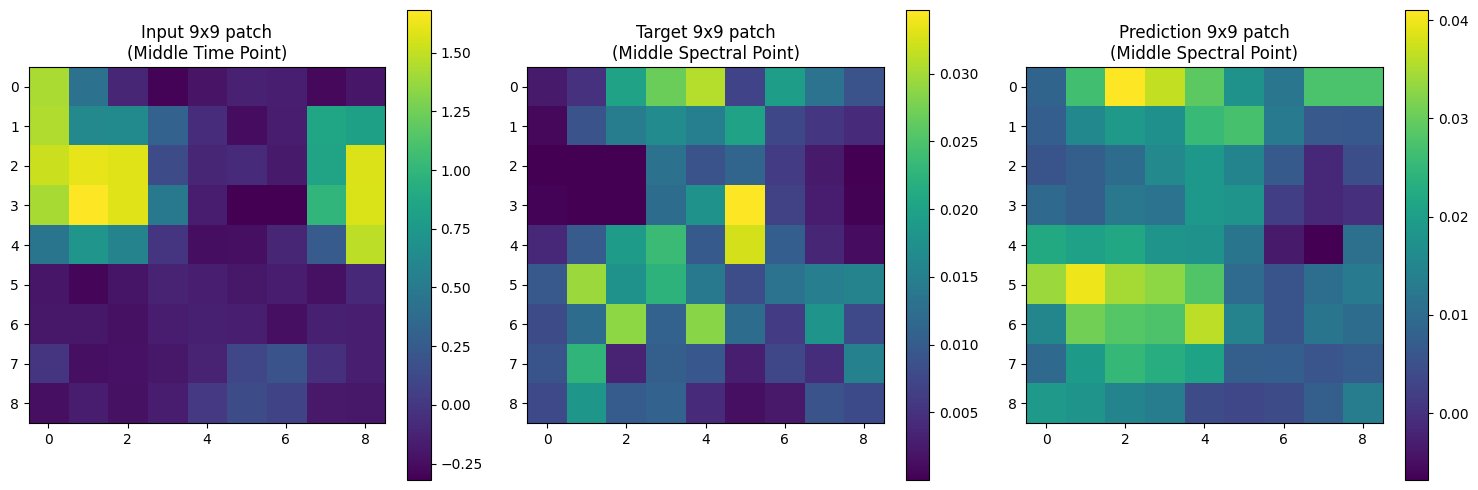

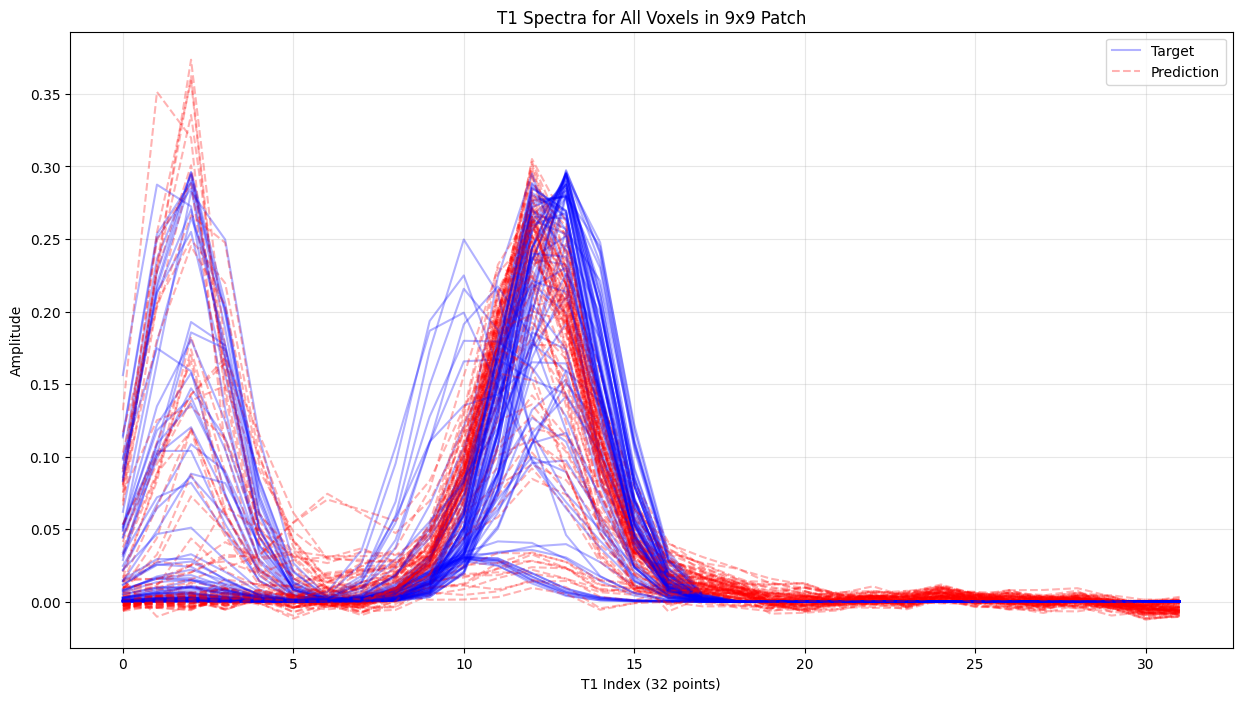

Full 9x9 patch MSE: 0.000575
Full 9x9 patch MAE: 0.012675

Mean Voxel MSE: 0.000575
Std Voxel MSE: 0.000429
Min Voxel MSE: 0.000032
Max Voxel MSE: 0.002045


In [ ]:
inputs, targets = next(iter(val_loader))
inputs, targets = inputs.to(device), targets.to(device)

with torch.no_grad():
    outputs = model(inputs)

inputs = inputs.cpu().numpy()
targets = targets.cpu().numpy()
outputs = outputs.cpu().numpy()

example_idx = 0

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(inputs[example_idx, 4, :, :])  # Middle temporal slice (4 out of 8)
plt.title('Input 9x9 patch\n(Middle Time Point)')
plt.colorbar()

plt.subplot(132)
plt.imshow(targets[example_idx, 16, :, :])  # Middle spectral point (16 out of 32)
plt.title('Target 9x9 patch\n(Middle Spectral Point)')
plt.colorbar()

plt.subplot(133)
plt.imshow(outputs[example_idx, 16, :, :])  # Middle spectral point
plt.title('Prediction 9x9 patch\n(Middle Spectral Point)')
plt.colorbar()

plt.tight_layout()
plt.show()

# Plot all 81 voxels (9x9) in a single plot
plt.figure(figsize=(15, 8))

# Plot all voxels
for i in range(9):
    for j in range(9):
        plt.plot(targets[example_idx, :, i, j], 'b-', alpha=0.3, label='Target' if i==0 and j==0 else "")
        plt.plot(outputs[example_idx, :, i, j], 'r--', alpha=0.3, label='Prediction' if i==0 and j==0 else "")

plt.title('T1 Spectra for All Voxels in 9x9 Patch')
plt.xlabel('T1 Index (32 points)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print metrics for the whole 9x9 patch
patch_mse = np.mean((targets[example_idx] - outputs[example_idx])**2)
patch_mae = np.mean(np.abs(targets[example_idx] - outputs[example_idx]))
print(f"Full 9x9 patch MSE: {patch_mse:.6f}")
print(f"Full 9x9 patch MAE: {patch_mae:.6f}")

# Calculate statistics of individual voxel MSEs
voxel_mses = []
for i in range(9):
    for j in range(9):
        mse = np.mean((targets[example_idx, :, i, j] - outputs[example_idx, :, i, j])**2)
        voxel_mses.append(mse)

print(f"\nMean Voxel MSE: {np.mean(voxel_mses):.6f}")
print(f"Std Voxel MSE: {np.std(voxel_mses):.6f}")
print(f"Min Voxel MSE: {np.min(voxel_mses):.6f}")
print(f"Max Voxel MSE: {np.max(voxel_mses):.6f}")

In [20]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
final_mae,▁
final_mse,▁
final_psnr,▁
final_r2_score,▁
inference_time_ms,▁
learning_rate,█████████████████████████████████████▁▁▁
memory_usage_mb,▁
model_parameters,▁
peak_detection_accuracy,▁
train_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
